# New York
This will be an interesting one.  New York had an exponential increase in cases early in the year, followed by a steep drop-off and the cases have leveled out completely.  They haven't disappeared, but compared to the population and where they were, the situation definitely appears under control.  Let's go ahead and get started!   

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import helper_functions
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data
from helper_functions import plot_loss
from helper_functions import LSTM_prediction_plot
import pmdarima as pm

Using TensorFlow backend.


In [2]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import itertools
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error as MSE
    from statsmodels.tsa.seasonal import seasonal_decompose
    

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

# SARIMA

Time to load up the data.

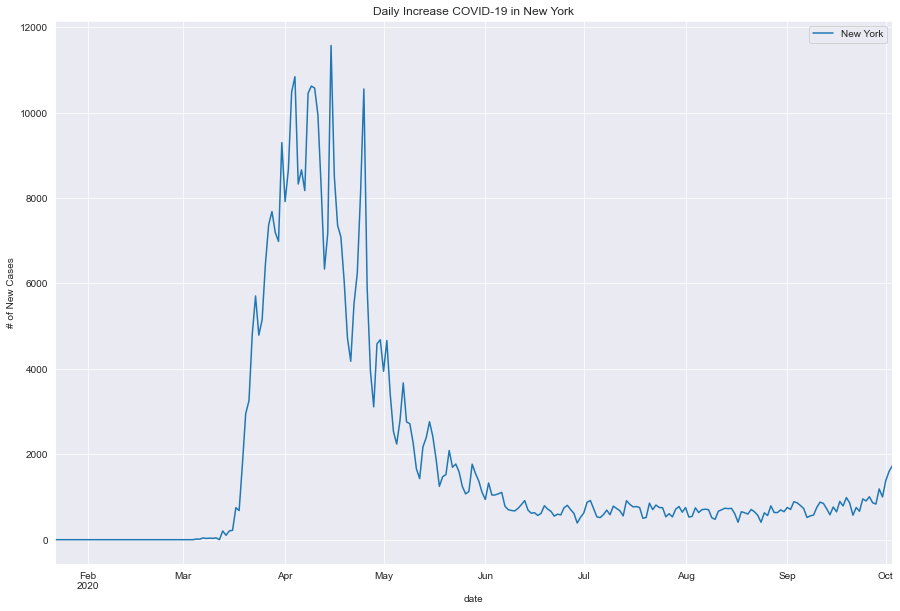

In [3]:
df = pd.read_csv('national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# New York
ny = df['NY_positiveIncrease']
ny.plot(figsize=(15, 10), label='New York')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in New York')
plt.legend()
plt.show();


As we've done before, we're going to forgo the stationarity check since it's obviously non-stationary.



## ACF and PACF

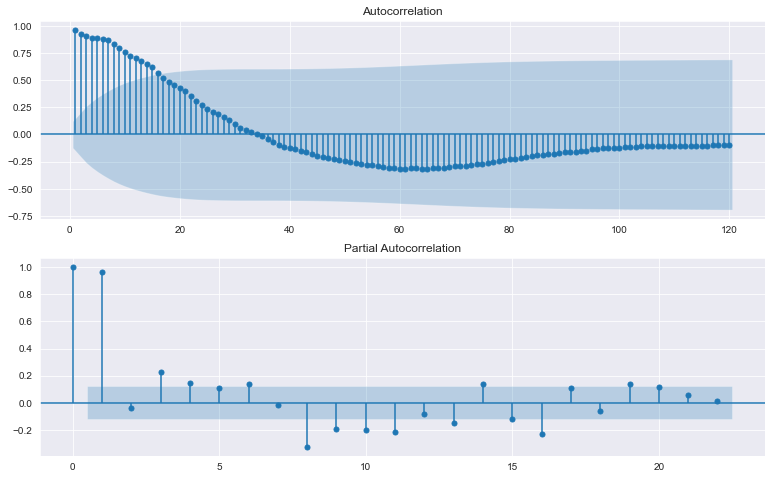

In [4]:
acf_pacf(ny)

New York proves to be pretty different from the other states.  The AR(`p`) term is 1 lag and the MA(`q`) term is up to 15 (our lowest values yet).

## Decomposition

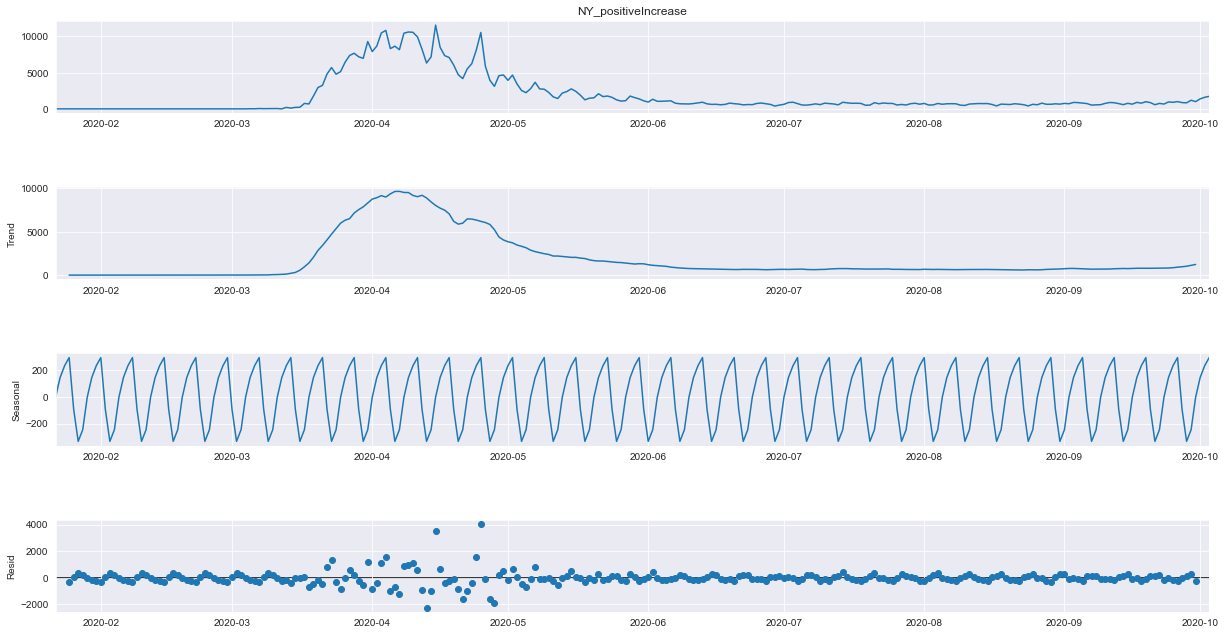

In [5]:
decompose_time_series(ny)

Again, there's an exponential trend in both directions again, seasonality is still weekly and the residuals are normally distributed, then they explode, and then they return to a pretty homoskedastic distribution.  The major difference is that the drastic increase in cases occurs during the spring as opposed to the summer.

## Auto ARIMA

In [6]:
ny_results = pm.auto_arima(ny, information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=1, max_q=15,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ny_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4036.165, BIC=4057.412, Fit time=0.690 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4070.518, BIC=4077.601, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4047.866, BIC=4062.032, Fit time=0.276 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4053.757, BIC=4067.922, Fit time=0.261 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4045.224, BIC=4062.931, Fit time=0.637 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 7); AIC=4038.059, BIC=4062.848, Fit time=1.141 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=4037.521, BIC=4055.227, Fit time=0.554 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=4038.328, BIC=4063.117, Fit time=1.220 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4068.324, BIC=4082.489, Fit time=0.287 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Our order is (1, 1, 4) and our seasonal order is (2, 0, 0, 7).  Very interesting how the Seasonal AR term has 2 lags when we saw that 

## Train-Test Split

In [7]:
ny_train, ny_test = train_test(ny)

## Model Fitting

                                     SARIMAX Results                                      
Dep. Variable:                NY_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(1, 1, 4)x(2, 0, [], 7)   Log Likelihood               -1624.415
Date:                            Thu, 15 Oct 2020   AIC                           3264.831
Time:                                    16:45:33   BIC                           3291.375
Sample:                                01-22-2020   HQIC                          3275.568
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8193      0.078     10.519      0.000       0.667       0.972
ma.L1         -0.9551      0.084   

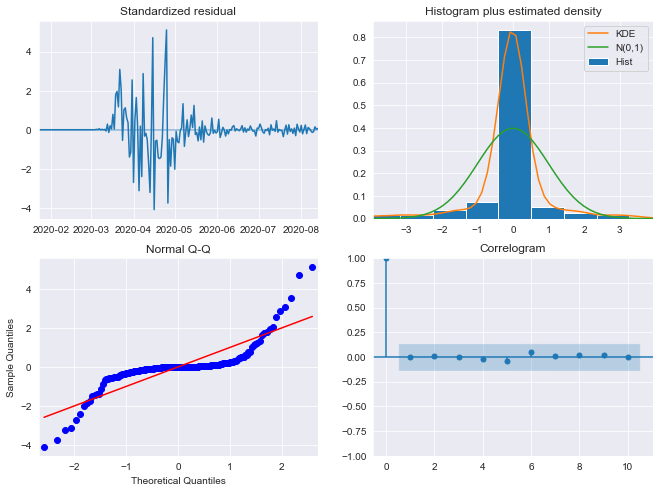

In [10]:
pdq = (1, 1, 4)
pdqs = (2, 0, 0, 7)
results = fit_model(ny_train, pdq=pdq, pdqs=pdqs)

## Results

### RMSE and Prediction Plots.

SARIMA model RMSE on train data: 116.43588


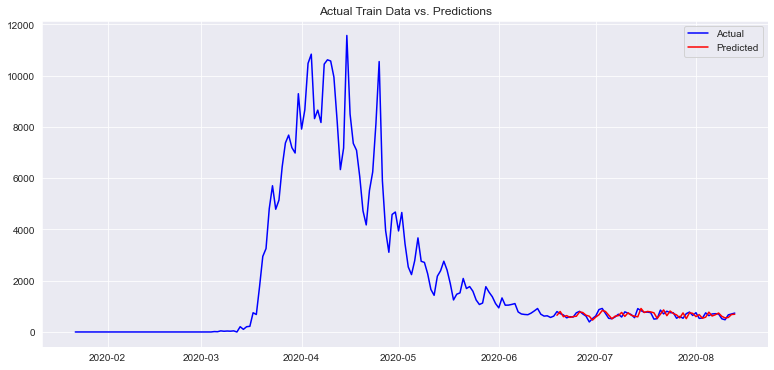

In [11]:
train_RMSE(ny_train, results, display = True)

SARIMA model RMSE on test data: 135.53368


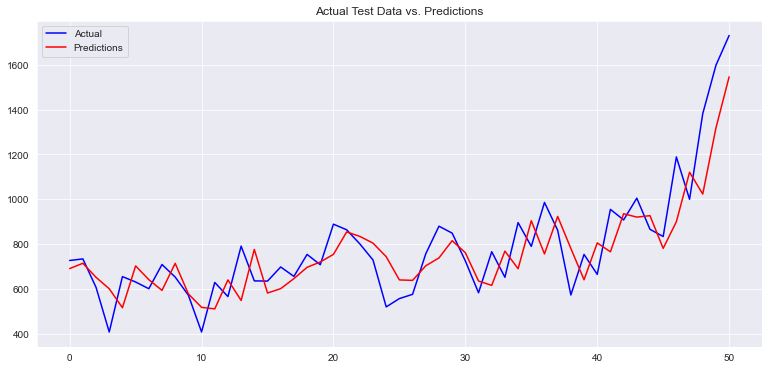

In [12]:
test_RMSE(ny_train, ny_test, pdq, pdqs, display=True)

# LSTM

In [19]:
ny_train, ny_val, ny_test = preprocess_data(ny, 'NY_positiveIncrease')

print(f"Train has {len(ny_train)} values")
print(f"Validation has {len(ny_val)} values")
print(f"Test has {len(ny_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


In [36]:
look_back = 1

X_train, y_train = create_dataset(ny_train, look_back)
X_val, y_val = create_dataset(ny_val, look_back)
X_test, y_test = create_dataset(ny_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [37]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 4ms/step - loss: 0.0849 - val_loss: 0.0027
Epoch 2/500
233/233 [==============================] - 0s 77us/step - loss: 0.0789 - val_loss: 0.0016
Epoch 3/500
233/233 [==============================] - 0s 64us/step - loss: 0.0737 - val_loss: 8.3671e-04
Epoch 4/500
233/233 [==============================] - 0s 77us/step - loss: 0.0697 - val_loss: 3.5129e-04
Epoch 5/500
233/233 [==============================] - 0s 99us/step - loss: 0.0656 - val_loss: 1.2013e-04
Epoch 6/500
233/233 [==============================] - 0s 77us/step - loss: 0.0619 - val_loss: 1.1378e-04
Epoch 7/500
233/233 [==============================] - 0s 73us/step - loss: 0.0591 - val_loss: 2.9937e-04
Epoch 8/500
233/233 [==============================] - 0s 73us/step - loss: 0.0562 - val_loss: 6.4645e-04
Epoch 9/500
233/233 [==============================] - 0s 69us/step - loss: 0.0537 - val_loss: 0.0011
Epoch 10/500
23

Epoch 79/500
233/233 [==============================] - 0s 73us/step - loss: 0.0045 - val_loss: 2.6526e-04
Epoch 80/500
233/233 [==============================] - 0s 69us/step - loss: 0.0040 - val_loss: 2.5055e-04
Epoch 81/500
233/233 [==============================] - 0s 69us/step - loss: 0.0048 - val_loss: 2.3975e-04
Epoch 82/500
233/233 [==============================] - 0s 60us/step - loss: 0.0050 - val_loss: 2.3114e-04
Epoch 83/500
233/233 [==============================] - 0s 69us/step - loss: 0.0041 - val_loss: 2.2658e-04
Epoch 84/500
233/233 [==============================] - 0s 81us/step - loss: 0.0041 - val_loss: 2.2268e-04
Epoch 85/500
233/233 [==============================] - 0s 63us/step - loss: 0.0049 - val_loss: 2.1417e-04
Epoch 86/500
233/233 [==============================] - 0s 51us/step - loss: 0.0044 - val_loss: 2.0553e-04
Epoch 87/500
233/233 [==============================] - 0s 94us/step - loss: 0.0054 - val_loss: 1.9783e-04
Epoch 88/500
233/233 [===============

In [38]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 374.64318029051685
Train Root Mean Squared Error: 745.6631420611346
Test Mean Absolute Error: 189.5708160400391
Test Root Mean Squared Error: 215.12584478023967


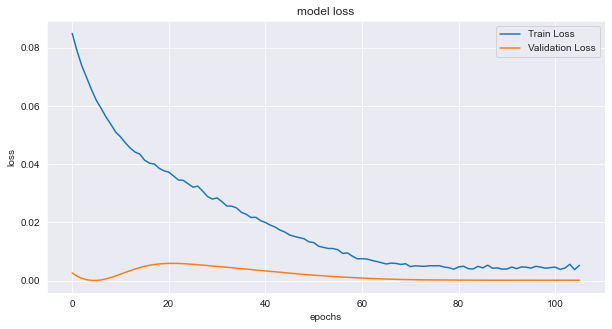

In [39]:
plot_loss(history)

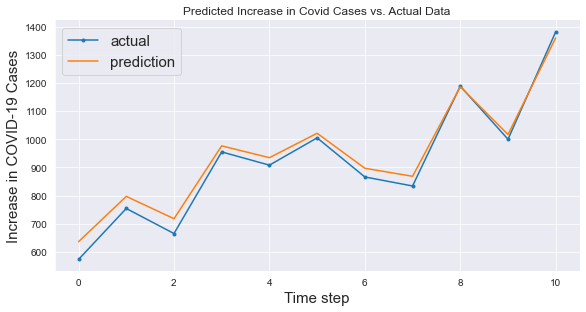

In [40]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

This plot represents the dates between September 21st and October 1st. These correspond with Time steps 38 through 48 of the Test Prediction plot of the SARIMA model.  When you compare these two sections, this model is still a much better fit, despite having a larger RMSE.